# Pendientes

* HECHO - convertir control en diccionario
* script mas complejo para proporcion
    - puede haber nulos, solucionar los faltantes
    - poder darle una lista de meses
* HECHO - arreglar scripts para control
* reescribir optimizacion de hiperparam
* arreglar teste de perdida al final

In [3]:
from datetime import datetime
import pandas as pd
import sys
import json
import os

# Archivos:
Luego del original, sell_in q es el source con millones de datos

- "group": solo numero de grupo, periodo, y tb. Punto de partida para las predicciones
- "prod_stats": identificador por grupo, media, maximos, minimos y otras estadisticas
- "prod_data_group": informacion sobre los productos, agrupado nivel grupo (groupby cats, descripcion etc)
- "prod_data_ungroup": informacion sobre los productos original, intacto del source
- "stock_data": info de stocks, intacto del source
- "norm": la informacion de "group" normalizada por media y desvio, columna tn_norm
- "lag": sigue luego de norm, mismas filas pero incorporando todo el feature engineering (no solo lags)
- "train": set de datos para train a partir de "lag" con los meses segun config
- "test": set de datos para test a partir de "lag" con los meses segun config
- "futuro": set de datos para futuro a partir de "lag" con los meses segun config
- "pred_test": predicciones de test, con algunas columnas accesorias
- "pred_futuro": predicciones de futuro, con algunas columnas accesorias
- "kaggle": prediccion en formato kaggle para el submit

In [4]:
ejecutar_scripts = {
    '01_LecturaDatos' : False,
    '02_normaliza': False,
    '02b_DTW' : False,
    '03_features' : False,
    '04_crear_train_set' : False,
    '05_lightgbm' : False,
    '06_evaluar_prediccion' : False	
}

In [27]:
NOMBRE_EXPERIMENTO = '2024-06-27_NivelProducto'
FOLDER = f'./Experimentos/{NOMBRE_EXPERIMENTO}/'

dibujar_pesos = False
lgbm_params = {
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'boosting_type': 'gbdt',
        'bagging_fraction': 0.9,
        'bagging_freq': 1,
    'num_leaves': 40,
    'max_depth': -1,
    #'n_estimators': 50, 
    'feature_fraction': 0.9,
    'max_bin': 1023,
    'learning_rate': 0.015,
    'force_col_wise' : True,
    'num_threads' : 8,
    'verbose' : 1
}

gen_config = {
    "nombre_exp" : NOMBRE_EXPERIMENTO,
    "folder" : FOLDER,
    "path_group" : "01_group.parquet",
    "path_prod_stats" : "01_prod_stats.parquet",
    "path_prod_data" : "01_prod_data.parquet",
    "path_stock_data" : "01_stock_data.parquet",
    "path_norm" : "02_norm.parquet",
    "path_dtw" : "02b_dtw.parquet",
    "path_traindtw" : "02b_traindtw.npy",
    "path_fitdtw" : "02b_fitdtw.npy",
    "path_dtw_model" : "02b_dtw_model.pkl",
    "path_lag" : "03_lag.parquet",
    "path_train" : "04_train.parquet",
    "path_test" : "04_test.parquet",
    "path_futuro" : "04_futuro.parquet",
    "path_pred_test" : "05_pred_test.parquet",
    "path_pred_futuro" : "05_pred_futuro.parquet",
    "path_kaggle" : f"kaggle_{NOMBRE_EXPERIMENTO}.csv",

    #"var_periodo_rep_start" : 201912,
    #"var_periodo_rep_end" : 201912,
    "var_ejecutar_dtw": True,
    "var_clusters": [10],
    "var_dibujar_dtw": False, #no poner true si no se rehacen los modelos
    "var_corte_prod_dtw" : 20100,
    "var_leer_pickle_dtw" : True,
    "var_lags": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 21, 24, 30, 36],
    "var_cates_feat" : ['cat1', 'cat2', 'brand', 'descripcion'],
    "var_exclusiones" : [],

    "var_periodo_train_start" : 201701,
    "var_periodo_train_end" : 201910,
    "var_periodo_test" : 201910,
    "var_periodo_futuro" : 201912,

    "var_num_boost_round": 2000,
    "var_lgbm_params" : lgbm_params,
    "var_dibujar_pesos" : dibujar_pesos,
}

with open('gen_config.json', 'w') as file:
    json.dump(gen_config, file, indent=4)

if not os.path.exists(FOLDER):
    os.makedirs(FOLDER)
with open(f'{FOLDER}\gen_config.json', 'w') as file:
    json.dump(gen_config, file, indent=4)

In [28]:
original_stdout = sys.stdout 

with open(f'{FOLDER}\exp_config_out.txt', 'w') as file:
    sys.stdout = file

    print(f"{'Experimento':.^120}\n{gen_config['nombre_exp']:-^120}")
    print(f"{'CARPETA':.<25}: {gen_config['folder']}")
    for k, v in gen_config.items():
        if k == 'folder' or k == 'nombre_exp':
            continue
        if k.startswith('path_'):
            print(f"{k:.<25}: {v} ( {FOLDER}{v} )")
        if k.startswith('var_'):
            print(f"{k:.<25}: {v}")

sys.stdout = original_stdout

with open(f'{FOLDER}\exp_config_out.txt', 'r') as file:
    print(file.read())

......................................................Experimento.......................................................
------------------------------------------------2024-06-27_NivelProducto------------------------------------------------
CARPETA..................: ./Experimentos/2024-06-27_NivelProducto/
path_group...............: 01_group.parquet ( ./Experimentos/2024-06-27_NivelProducto/01_group.parquet )
path_prod_stats..........: 01_prod_stats.parquet ( ./Experimentos/2024-06-27_NivelProducto/01_prod_stats.parquet )
path_prod_data...........: 01_prod_data.parquet ( ./Experimentos/2024-06-27_NivelProducto/01_prod_data.parquet )
path_stock_data..........: 01_stock_data.parquet ( ./Experimentos/2024-06-27_NivelProducto/01_stock_data.parquet )
path_norm................: 02_norm.parquet ( ./Experimentos/2024-06-27_NivelProducto/02_norm.parquet )
path_dtw.................: 02b_dtw.parquet ( ./Experimentos/2024-06-27_NivelProducto/02b_dtw.parquet )
path_traindtw............: 02b_train

In [6]:
if ejecutar_scripts['01_LecturaDatos']:
    print('')
    %run 01_LecturaDatos.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'01_LecturaDatos':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['02_normaliza']:
    print('')
    %run 02_normaliza.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'02_normaliza':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['02b_DTW']:
    print('')
    %run 02b_DTW.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'02b_DTW':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['03_features']:
    print('')
    %run 03_features.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'03_features':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['04_crear_train_set']:
    print('')
    %run 04_crear_train_set.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'04_crear_train_set':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['05_lightgbm']:
    print('')
    %run 05_lightgbm.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'05_lightgbm':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")

if ejecutar_scripts['06_evaluar_prediccion']:
    print('')
    %run 06_evaluar_prediccion.ipynb
else:
    print(f"{'SALTEADO':-^100}")
    print(f"{'06_evaluar_prediccion':-^100}")
    print(f"{'SALTEADO':-^100}\n\n\n")


----------------------------------------------SALTEADO----------------------------------------------
------------------------------------------01_LecturaDatos-------------------------------------------
----------------------------------------------SALTEADO----------------------------------------------



----------------------------------------------SALTEADO----------------------------------------------
--------------------------------------------02_normaliza--------------------------------------------
----------------------------------------------SALTEADO----------------------------------------------



----------------------------------------------SALTEADO----------------------------------------------
----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------SALTEADO----------------------------------------------



----------------------------------------------SALTEADO----------------------------

----------------------------------------------COMIENZA----------------------------------------------
------------------------------------------01_LecturaDatos-------------------------------------------
Tamaño prod_stats........: (780, 11)
------------------------------------------01_LecturaDatos-------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



----------------------------------------------COMIENZA----------------------------------------------
--------------------------------------------02_normaliza--------------------------------------------
--------------------------------------------02_normaliza--------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



----------------------------------------------COMIENZA----------------------------------------------
----------------------------------------------02

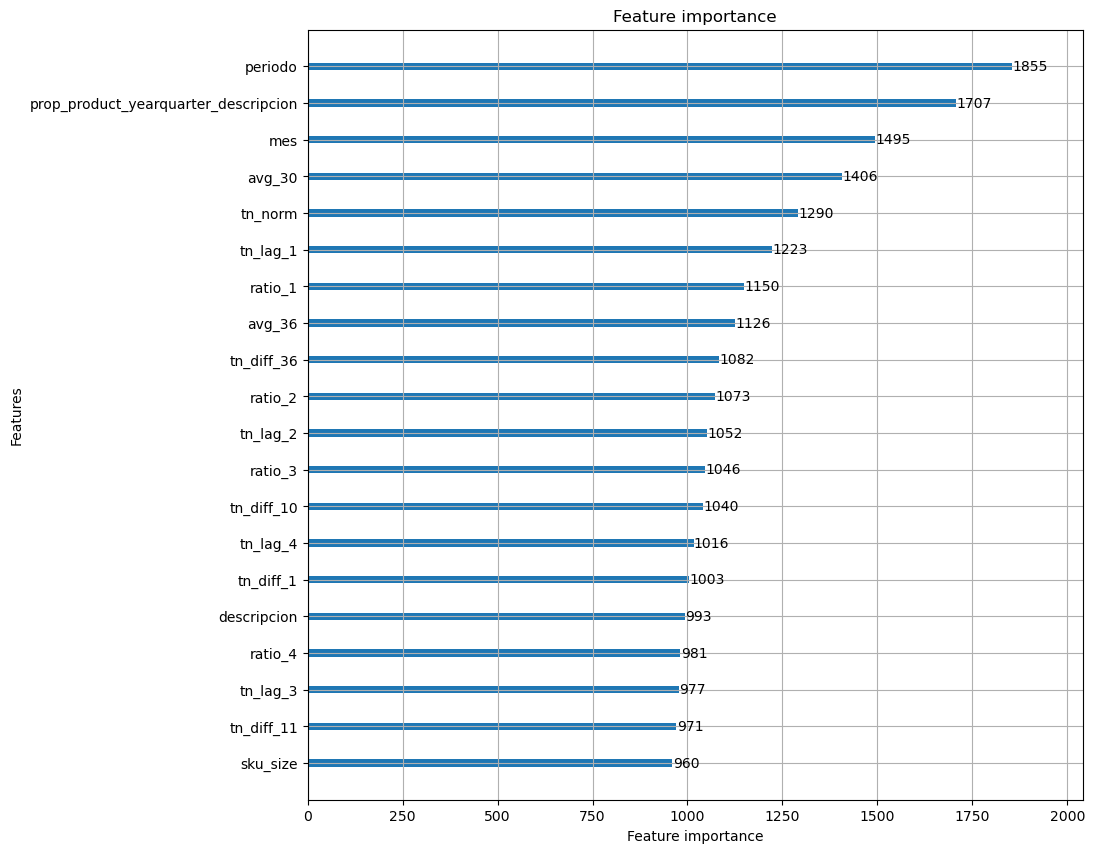

--------------------------------------05_lightgbm (un intento)--------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



----------------------------------------------COMIENZA----------------------------------------------
---------------------------------------06_evaluar_prediccion----------------------------------------
Perdida en test (sin desagrupar): 0.10449882403833595
Primeras filas de test:
    product_id  tn_futuro_real  tn_prediccion_real     error
0        20001      1504.68856         1373.235898 -8.736204
1        20002      1087.30855         1065.299239 -2.024201
2        20003       892.50129          813.384440 -8.864620
3        20004       637.90002          601.811863 -5.657338
4        20005       593.24443          564.448657 -4.853947
31       20032       527.79811          535.986410  1.551408
Primeras filas de futuro:
   product_id  tn_futuro_real  tn_prediccion_real
0       2000

In [157]:
# %run 01_LecturaDatos.ipynb
# %run 02_normaliza.ipynb
# %run 02b_DTW.ipynb
# %run 03_features.ipynb
# %run 04_crear_train_set.ipynb
# %run 05_lightgbm.ipynb
# %run 06_evaluar_prediccion.ipynb